# Credit Scoring Model


### Introduction

This is a notebook which comes originally from  https://www.kaggle.com/code/ajay1735/my-credit-scoring-model, which was slightly modified to show how to transform it to use Concrete-ML models and have privacy for free. Credits go to Ajay Vallala. Minor modifications done notably to handle changes in libraries or comply with our formatting rules and checks.

#### Objective : Create a credit scoring algorithm that predicts the chance of a given loan applicant defaulting on loan repayment.

In [1]:
# Importing necessary libraries
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
# Reading the input
# Storing it in 2 dataframes, We will carry out our operations on df. In case of need
# for initial table without any changes we can use df_i
df = pd.read_csv("hmeq.csv")
df_i = pd.read_csv("hmeq.csv")

In [3]:
# Glimpse of the dataset
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# Understanding the data

In [4]:
print(df.shape)

(5960, 13)


In [5]:
# Number of entries that are not Nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
# Descriptive stats
# Distribution of the data
# There are no anomalies in the data (observe the maximums and means in each case)
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [7]:
# Columns of the dataset
print(df.columns)

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')


## Distributions of various variables

0    4771
1    1189
Name: BAD, dtype: int64


<Axes: >

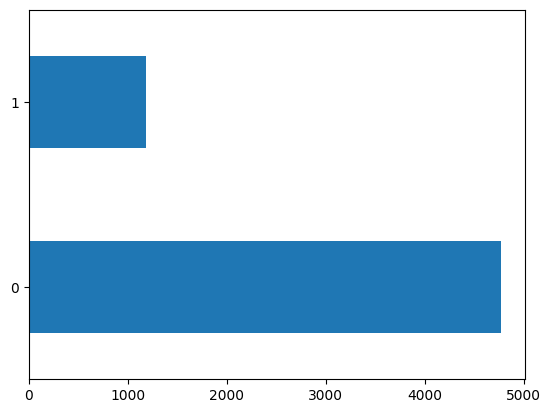

In [8]:
# Distribution of target variable "BAD"
# The target class is a bit unbalanced - zeroes are about 80% and ones are about 20%
print(df["BAD"].value_counts())
df["BAD"].value_counts().plot(kind="barh")

In [9]:
# This is a nominal feature, It must be modified in a way we can use it.
print(df["REASON"].value_counts())

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64


In [10]:
# Same as the above case, we must find a way to use it.
print(df["JOB"].value_counts())

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


<Axes: ylabel='Frequency'>

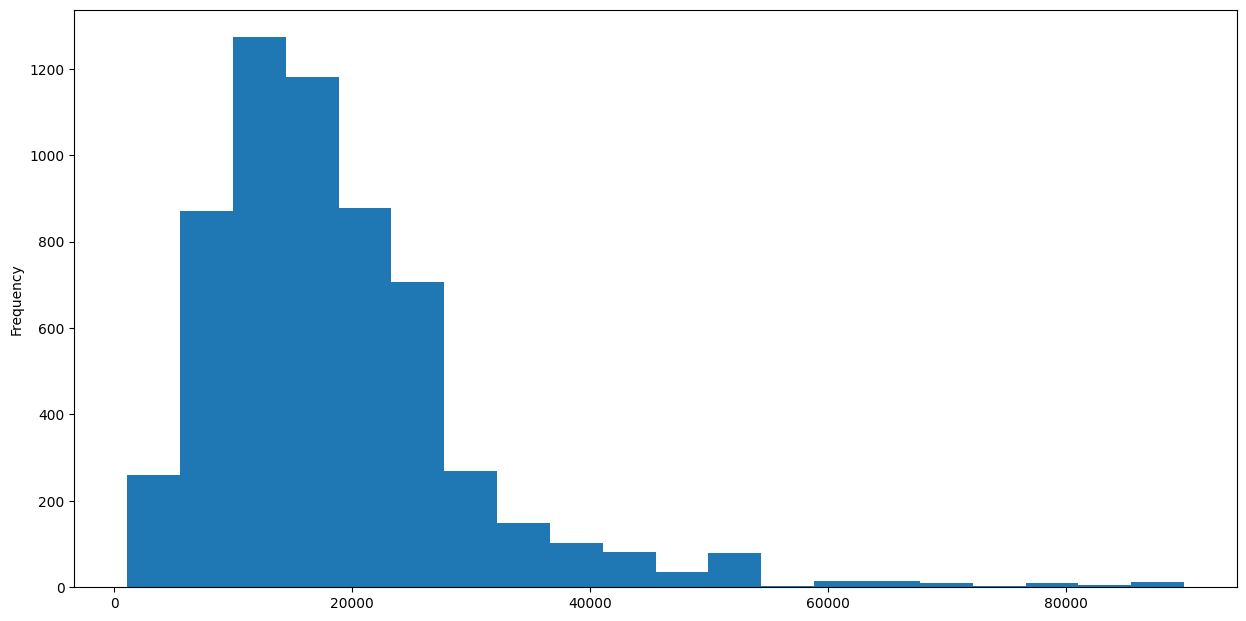

In [11]:
# Distribution of loan variable
# Density between 10000-30000 is high
df["LOAN"].plot.hist(bins=20, figsize=(15, 7.5))

<Axes: ylabel='Frequency'>

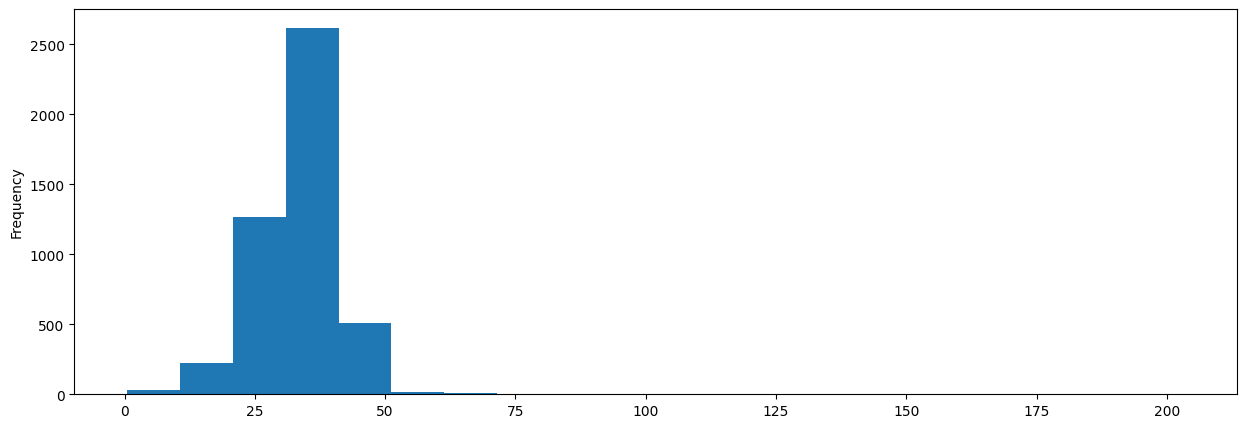

In [12]:
# Highly populated around 25-50
# We may cap off the end values if required.
df["DEBTINC"].plot.hist(bins=20, figsize=(15, 5))

<Axes: ylabel='Frequency'>

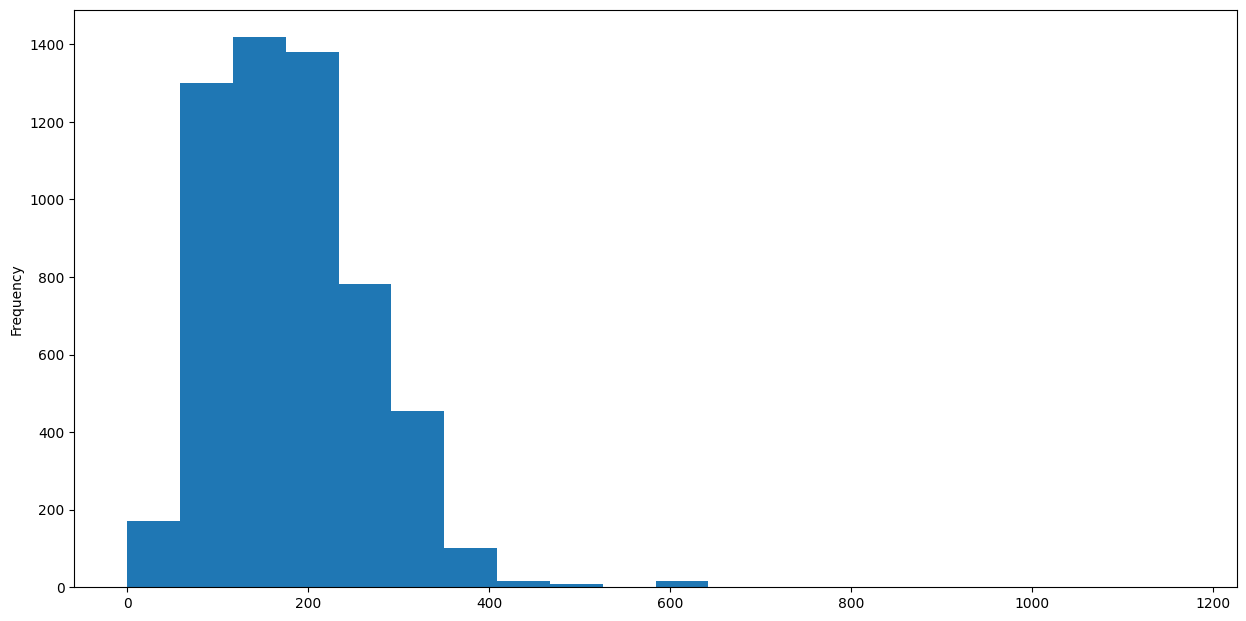

In [13]:
# Density is high around 100-300
# We can cap off the values >= 600 to get better results
df["CLAGE"].plot.hist(bins=20, figsize=(15, 7.5))

<Axes: ylabel='Frequency'>

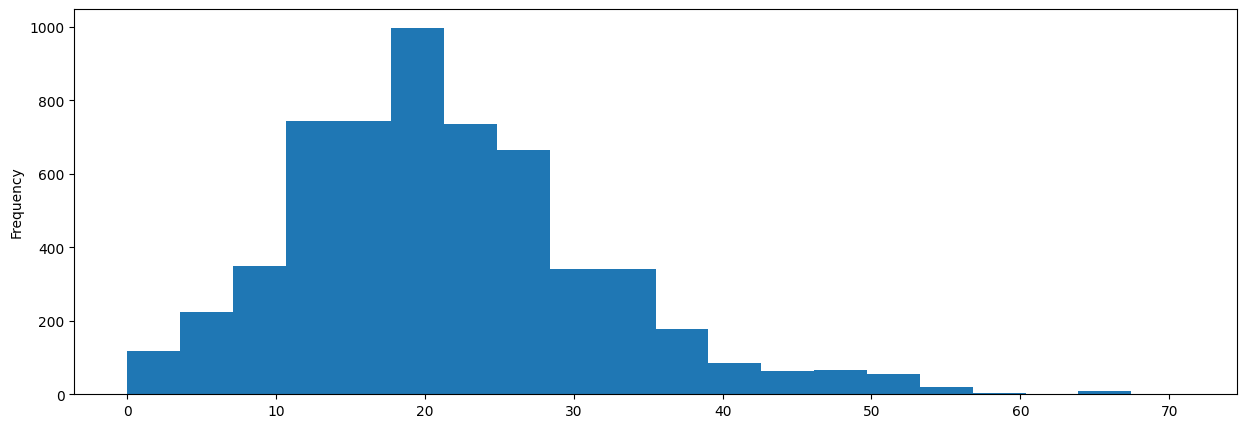

In [14]:
# This distribution looks good and we need not modify anything here.
df["CLNO"].plot.hist(bins=20, figsize=(15, 5))

<Axes: ylabel='Frequency'>

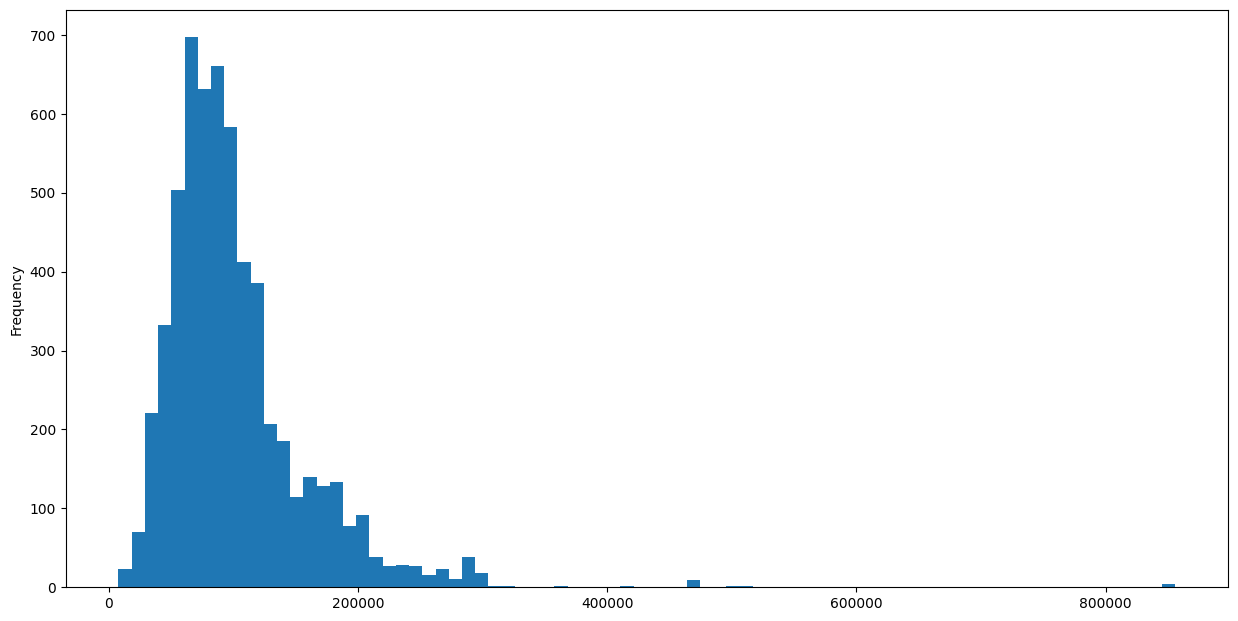

In [15]:
# Concentration is high around 80000-100000
# There are very less values at the end(>= 400000) that are a bit high compared to mean. We can cap
# these off.
df["VALUE"].plot.hist(bins=80, figsize=(15, 7.5))

<Axes: ylabel='Frequency'>

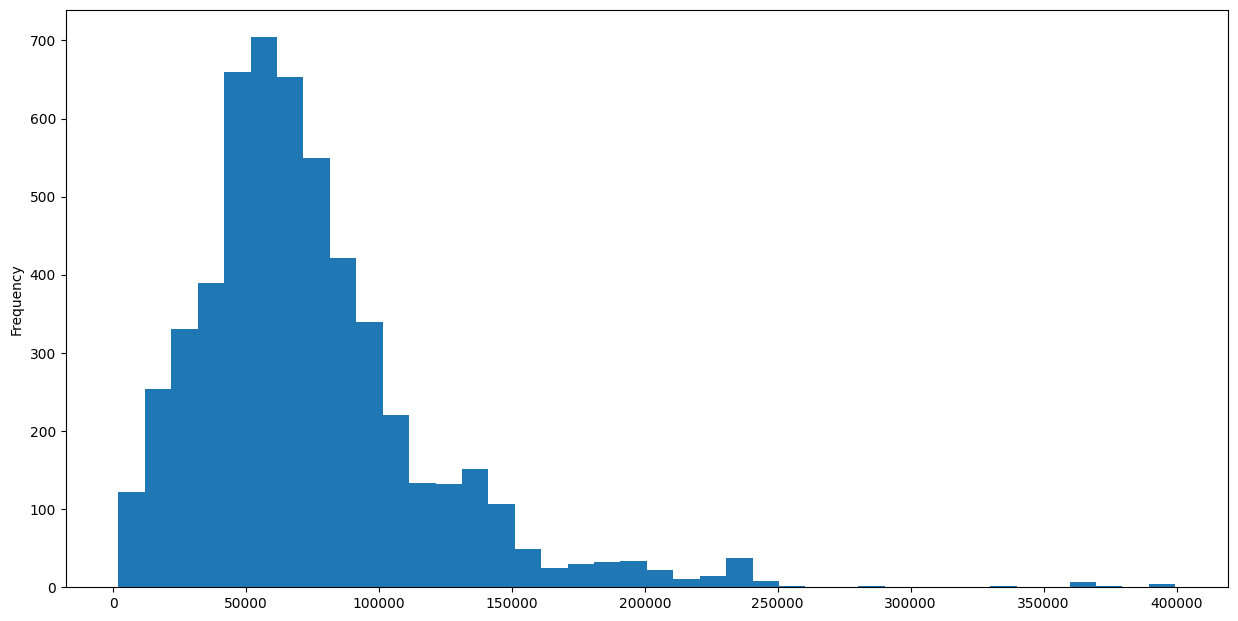

In [16]:
# Concentration is high around 40000-100000
# The values at the end(>= 300000) can be capped off.
df["MORTDUE"].plot.hist(bins=40, figsize=(15, 7.5))

<Axes: ylabel='Frequency'>

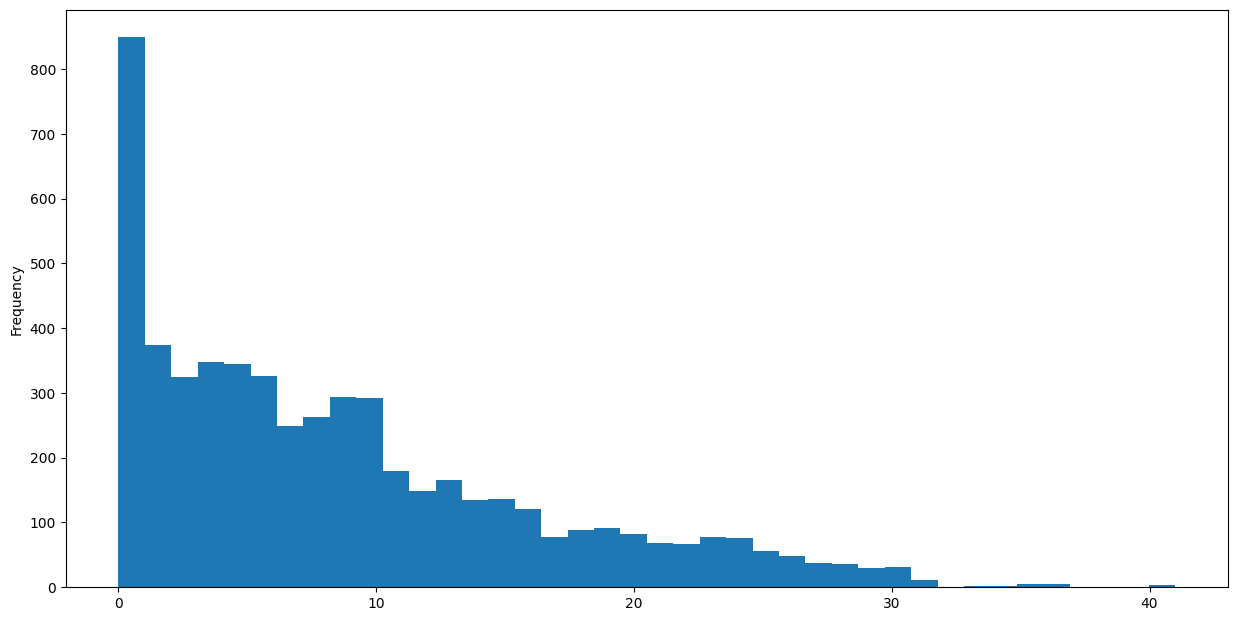

In [17]:
# This is very skewed. It would be better if we modify this variable to decrease the skewness.
df["YOJ"].plot.hist(bins=40, figsize=(15, 7.5))

In [18]:
# Derogatory incidents were reported only in few cases.
# So,creating a binary variable with values 1 for atleast one derogatory incident and 0 for no
# such report may be useful.
df["DEROG"].value_counts()

0.0     4527
1.0      435
2.0      160
3.0       58
4.0       23
5.0       15
6.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

In [19]:
# Most of them are zero.
# Same as in above case creating a binary variable would be useful.
df["DELINQ"].value_counts()

0.0     4179
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
10.0       2
11.0       2
15.0       1
12.0       1
13.0       1
Name: DELINQ, dtype: int64

In [20]:
# Distributed mostly among first five values
df["NINQ"].value_counts()

0.0     2531
1.0     1339
2.0      780
3.0      392
4.0      156
5.0       75
6.0       56
7.0       44
10.0      28
8.0       22
9.0       11
11.0      10
12.0       2
13.0       2
14.0       1
17.0       1
Name: NINQ, dtype: int64

#### Conclusions :

- The distributions are fine and there are no anomalies in the data.
<br>
- DEBTINC has very high number of missing data (will be taken care of in next section - Imputing the variables).
<br>
- The feature YOJ is highly skewed and may be modified to decrease skewness.
<br>
- Nominal features : JOB and REASON must be modified in a way that we can use them for logistic regression model.
<br>
- DELINQ, DEROG may be divided into 2 classes to create new binary variables.
<br>
- VALUE, MORTDUE, CLAGE,DEBTINC may be capped off at the end that is values that are very high will be set to a selected lower value.
-------------------------------------------------------------------------------------------------------------------------------

# Imputing the input variables
<br>

In [21]:
# Number of cases with Nan.
df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

#### Observations :
- Except in the case of DEBTINC, in all other cases only few values were not reported
- For imputing the missing values we can think of few ideas like :
    - In case of nominal features, replacing them with the majority class
    - In case of numeric variables like DEROG and DELINQ, most of the cases are 0. We can replace these with majority class.
    - In case of other numerical inputs, we can replace them by median or mean without modifying the much. In this notebook I am going to replace them by mean of the respective column.

In [22]:
# Nominal features
# Replacement using majority class
# Majority class in case of JOB variable is Other
# Majority class in case of REASON varibale is DebtCon
df["REASON"].fillna(value="DebtCon", inplace=True)
df["JOB"].fillna(value="Other", inplace=True)

In [23]:
df["DEROG"].fillna(value=0, inplace=True)
df["DELINQ"].fillna(value=0, inplace=True)

In [24]:
# Numeric features
# Replacement using mean of each class
df.fillna(value=df.mean(), inplace=True)

/var/folders/zf/w2q9lrs922d1d515bg7hkqmw0000gn/T/ipykernel_38092/4082273818.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(value=df.mean(), inplace=True)


In [25]:
# Checking if there is anything left out
# As you can see, all missing values are filled
df.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

##### Final look at the data after filling the missing values

In [26]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0000,39025.000000,HomeImp,Other,10.500000,0.0,0.0,94.366667,1.000000,9.000000,33.779915
1,1,1300,70053.0000,68400.000000,HomeImp,Other,7.000000,0.0,2.0,121.833333,0.000000,14.000000,33.779915
2,1,1500,13500.0000,16700.000000,HomeImp,Other,4.000000,0.0,0.0,149.466667,1.000000,10.000000,33.779915
3,1,1500,73760.8172,101776.048741,DebtCon,Other,8.922268,0.0,0.0,179.766275,1.186055,21.296096,33.779915
4,0,1700,97800.0000,112000.000000,HomeImp,Office,3.000000,0.0,0.0,93.333333,0.000000,14.000000,33.779915


# Applying the models on the data after imputation
- Applying the basic Classification on the data after replacement/imputation. Let's check the performance by applying both Logistic Regression and Decision tree algorithms.
- Before applying the algorithms, the data is split into training and testing sets in the ratio 2:1 that is test data 33% and train data 67%.
- And also taking all the columns except JOB, REASON as input features (as they are nominal features, they must be transformed to other variables to be usable which is taken care of in next section).

In [27]:
# Importing the required modules. Remark that here, we use Concrete-ML model, not scikit-learn model
from sklearn.model_selection import train_test_split

# With Concrete-ML, it is:
from concrete.ml.sklearn import LogisticRegression

# With scikit-learn, it was: from sklearn.linear_model import LogisticRegression


# Removing the features BAD,JOB,REASON from the input features set
x_basic = df.drop(columns=["BAD", "JOB", "REASON"])
y = df["BAD"]

# Spliting the data into test and train sets
x_basic_tr, x_basic_te, y_tr, y_te = train_test_split(x_basic, y, test_size=0.33, random_state=1)
logreg_basic = LogisticRegression()

# Training the basic logistic regression model with training set
logreg_basic.fit(x_basic_tr, y_tr)

# Printing the coefficients
print("intercept ")
# FIXME: does not work in Concrete-ML: print(logreg_basic.intercept_)
print("")
print("coefficients ")
# FIXME: does not work in Concrete-ML: print(logreg_basic.coef_)

# Predicting the output of the test cases using the algorithm created above
y_pre = logreg_basic.predict(x_basic_te)

# Validating the algorithm using various Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("")
a1 = accuracy_score(y_te, y_pre)
f1 = f1_score(y_te, y_pre, average="macro")
p1 = precision_score(y_te, y_pre, average="macro")
r1 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a1)
print("f1 score : ", f1)
print("precision score : ", p1)
print("recall score : ", r1)

intercept 

coefficients 

accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5


In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap="Blues"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


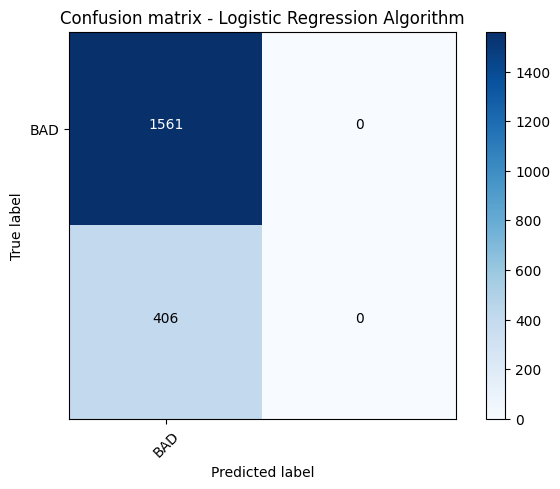

In [29]:
# Computing Confusion matrix for the above algorithm
cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=["BAD"], title="Confusion matrix - Logistic Regression Algorithm"
)

plt.show()

accuracy score :  0.871377732587697
f1 score :  0.798682020174234
precision score :  0.8068428783155992
recall score :  0.7913914599394729
Confusion matrix, without normalization
[[1448  113]
 [ 140  266]]


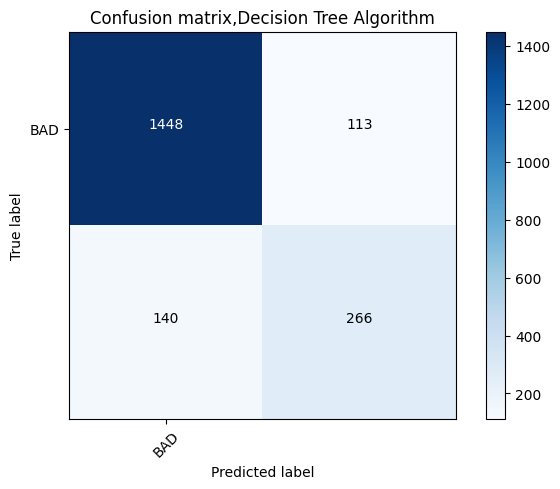

In [30]:
# With Concrete-ML, it is:
from concrete.ml.sklearn import DecisionTreeClassifier

# With scikit-learn, it was: from sklearn.tree import DecisionTreeClassifier

dectree_basic = DecisionTreeClassifier()
dectree_basic.max_depth = 100

# Training the basic Decision Tree model with training set
dectree_basic.fit(x_basic_tr, y_tr)

# Predicting the output of the test cases using the algorithm created above
y_pre = dectree_basic.predict(x_basic_te)

# Validating the algorithm using various Performance metrics
a2 = accuracy_score(y_te, y_pre)
f2 = f1_score(y_te, y_pre, average="macro")
p2 = precision_score(y_te, y_pre, average="macro")
r2 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a2)
print("f1 score : ", f2)
print("precision score : ", p2)
print("recall score : ", r2)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"], title="Confusion matrix,Decision Tree Algorithm")

plt.show()




#### Some discussion on Performance metrics :
- Generally, accuracy test can be used to evaluate algorithms. But in this case, just using the MAJORITY CLASS(0) to predict the output will give high(79.2%) accuracy. BUT WE WOULD END UP PREDICTING ALL "1" AS O's INSTEAD.
<br>
- Hence other performance metrics must be used to evaluate the model.And those would be
    - F1 score : Weighted mean of Recall and Precision
    - Recall : (TP/TP+FN)
    - Precision : (TP/TP+FP)
      TP is true positive,FN is false negative,FP is false positive
<br>
- Here we want to decrease the number of False Negatives i.e, We predict that credit will be repaid but it actually being a fraudant one. To decrease FN implies to increase Recall. Therefore, RECALL will the perfect Performance metric to evaluate this model.
<br>
- Precision may decrease in the process to increase recall but it is okay to predict some extra False Positives.
##### We can also RESAMPLE the data(We will get back to this at the end).

#### Conclusions :

- Using Logistic Regression though Accuracy is good(79%), the model did not perform well on other performance metrics. Recal is just above .5 and this is not good. This may be due to overfitting and we will try to remove this in the next section.
<br>
- Surprisingly, Decision Tree algorithm worked very well compared to Logistic Regression with a RECALL of about .78 and very good ACCURACY. This is because this model implicitly performs variable selection/feature selection by spliting the top nodes based on the most important features of the data and feature selection is done automatically.
<br>
- Finally what I want say that is :
    - There will be a good improvement in Logistic Regression model after Feature Selection.
    - The results will almost stay same in the case of Decision Tree model even after Feature Selection.
<br>
- We will prove the above hypothesis by creating models with selected features and compare them will the above models.

# Feature transformation

- Before Feature selection, as discussed in the section "Distribution of various Features" we need to transform some variables in order to improve predictability.
- We have transform the whole data set not just training set.

In [31]:
# Capping off the features CLAGE(values >= 600 to 600), VALUE(values>=400000 to 400000),
# MORTDUE(values>=300000 to 300000) and DEBTINC(values >=100 to 100)

df.loc[df["CLAGE"] >= 600, "CLAGE"] = 600
df.loc[df["VALUE"] >= 400000, "VALUE"] = 400000
df.loc[df["MORTDUE"] >= 300000, "MORTDUE"] = 300000
df.loc[df["DEBTINC"] >= 100, "DEBTINC"] = 100

In [32]:
# Creating new binary vaiables B_DEROG, B_DELINQ from DEROG,DELINQ

df["B_DEROG"] = (df["DEROG"] >= 1) * 1
df["B_DELINQ"] = (df["DELINQ"] >= 1) * 1

In [33]:
df["JOB"].unique()

array(['Other', 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'], dtype=object)

In [34]:
# We need to conert the nominal features JOB and REASON into usable form and remove them from the
# data table

df["REASON_1"] = (df["REASON"] == "HomeImp") * 1
df["REASON_2"] = (df["REASON"] != "HomeImp") * 1
df["JOB_1"] = (df["JOB"] == "Other") * 1
df["JOB_2"] = (df["JOB"] == "Office") * 1
df["JOB_3"] = (df["JOB"] == "Sales") * 1
df["JOB_4"] = (df["JOB"] == "Mgr") * 1
df["JOB_5"] = (df["JOB"] == "ProfExe") * 1
df["JOB_6"] = (df["JOB"] == "Self") * 1
df.drop(["JOB", "REASON"], axis=1, inplace=True)

# The above assignment creates new features for each JOB and each REASON

In [35]:
# We need to decrease the skewness of the feature YOJ,For that we can apply log of YOJ but since
# some of them are 0, we will use log(YOJ+constant)

df["YOJ"] = df["YOJ"].apply(lambda t: np.log(t + 1))

In [36]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,...,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,...,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,...,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,...,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,...,0,0,1,0,0,1,0,0,0,0


# Feature selection

- As we completed the transformation part, now we move on to Feature Selection. Now we will find out the most import features that are affecting the target variable "BAD" the most.
- We will use the following for this purpose :
    - Pearson correlation factor pearson
    - chi square test
    - f_regression
    - f_classif 

### Using Pearson Correlation factor for feature selection

In [37]:
# Finding correlation between all the features and the target feature "BAD"

df.corr(method="pearson")

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
BAD,1.000000,-0.075099,-0.049420,-0.043711,-0.053066,0.269921,0.346503,-0.173412,0.168851,-0.004067,...,0.261216,0.308153,0.037517,-0.037517,0.037949,-0.073613,0.050934,0.032583,-0.043561,0.046245
LOAN,-0.075099,1.000000,0.214803,0.338749,0.102458,0.006996,-0.028869,0.088875,0.043160,0.071804,...,0.009079,-0.030646,-0.151477,0.151477,-0.058067,-0.018060,-0.044993,0.018769,0.017488,0.158452
MORTDUE,-0.049420,0.214803,1.000000,0.816001,-0.052771,-0.046526,0.002095,0.132928,0.026853,0.314779,...,-0.041471,-0.014568,-0.026941,0.026941,-0.259602,-0.066813,0.026023,0.076687,0.256575,0.107944
VALUE,-0.043711,0.338749,0.816001,1.000000,0.023878,-0.041263,-0.000578,0.178638,-0.004635,0.283654,...,-0.040482,-0.034988,-0.012308,0.012308,-0.288132,-0.058463,0.018250,0.051960,0.282653,0.163060
YOJ,-0.053066,0.102458,-0.052771,0.023878,1.000000,-0.050552,0.023185,0.145111,-0.052621,0.042928,...,-0.058295,0.023075,0.060306,-0.060306,0.023324,-0.066539,-0.041243,0.029926,0.024664,-0.010586
DEROG,0.269921,0.006996,-0.046526,-0.041263,-0.050552,1.000000,0.171286,-0.081231,0.146700,0.050727,...,0.755021,0.171622,-0.008406,0.008406,0.034537,-0.049223,0.030659,0.031342,-0.033939,0.000836
DELINQ,0.346503,-0.028869,0.002095,-0.000578,0.023185,0.171286,1.000000,0.026713,0.057212,0.159378,...,0.188767,0.748356,0.004024,-0.004024,-0.044718,0.005268,-0.016502,0.059350,-0.002911,0.021694
CLAGE,-0.173412,0.088875,0.132928,0.178638,0.145111,-0.081231,0.026713,1.000000,-0.110857,0.242213,...,-0.083332,0.007707,0.050670,-0.050670,-0.080490,0.000032,0.026502,-0.022948,0.112309,-0.010872
NINQ,0.168851,0.043160,0.026853,-0.004635,-0.052621,0.146700,0.057212,-0.110857,1.000000,0.085148,...,0.152237,0.059767,-0.115992,0.115992,0.054470,-0.063735,-0.035677,0.069826,-0.061553,0.016229
CLNO,-0.004067,0.071804,0.314779,0.283654,0.042928,0.050727,0.159378,0.242213,0.085148,1.000000,...,0.035880,0.154674,-0.107224,0.107224,-0.197815,-0.004549,0.049185,0.060210,0.165109,0.031325


In [38]:
# Gathering the 2 feature sets with high peason correlation value,one with 7 and other with 10
# features in it

feat1 = ["DEROG", "DELINQ", "CLAGE", "NINQ", "DEBTINC", "YOJ", "LOAN"]
# feat2=["DEROG","DELINQ","CLAGE","NINQ","DEBTINC","LOAN","JOB_2","YOJ","JOB_3","MORTDUE"]

##### Now that we got the features with high correlation with the BAD feature, we will run the classification algorithms and compare them

accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5
Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


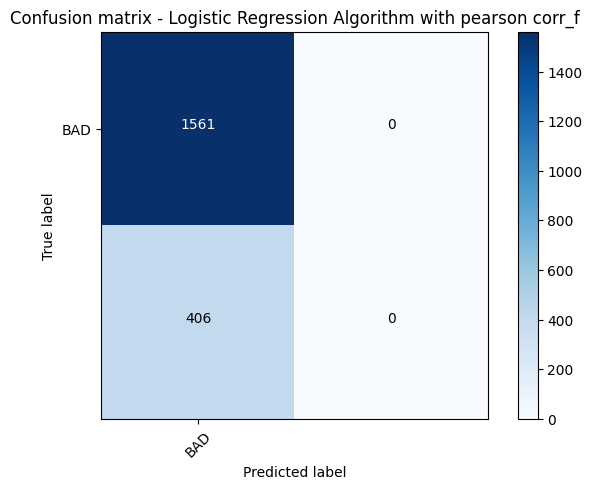

In [39]:
# Logistic Regression using above feature set 1

x = df[feat1]
y = df["BAD"]

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr, y_tr)
y_pre = logreg.predict(x_te)

a3 = accuracy_score(y_te, y_pre)
f3 = f1_score(y_te, y_pre, average="macro")
p3 = precision_score(y_te, y_pre, average="macro")
r3 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ", a3)
print("f1 score : ", f3)
print("precision score : ", p3)
print("recall score : ", r3)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Logistic Regression Algorithm with pearson corr_f",
)

plt.show()

accuracy score :  0.8490086426029486
f1 score :  0.7551108437623791
precision score :  0.774027344928119
recall score :  0.740849146214849

Confusion matrix, without normalization
[[1444  117]
 [ 180  226]]


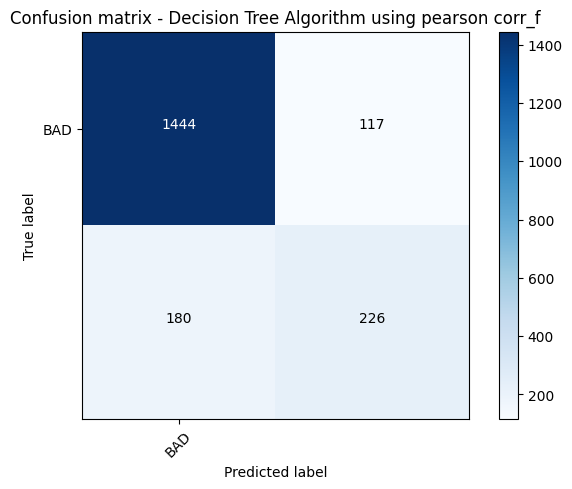

In [40]:
# Decision Tree classifier using feat1

clf_tree = DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr, y_tr)
y_pre = clf_tree.predict(x_te)

a4 = accuracy_score(y_te, y_pre)
f4 = f1_score(y_te, y_pre, average="macro")
p4 = precision_score(y_te, y_pre, average="macro")
r4 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a4)
print("f1 score : ", f4)
print("precision score : ", p4)
print("recall score : ", r4)
print("")

# Computing Confusion matrix for the above algorithm
cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Decision Tree Algorithm using pearson corr_f",
)

plt.show()

### Using chi2 test for feature selection

In [41]:
# Finding the best 10 features using chi2 test
from sklearn.feature_selection import SelectKBest, chi2

df_new = pd.DataFrame(SelectKBest(chi2, k=10).fit_transform(df.drop(["BAD"], axis=1), df["BAD"]))

In [42]:
# dataframe containing the selected features
df_new.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,25860.0000,39025.000000,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0
1,1300.0,70053.0000,68400.000000,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0
2,1500.0,13500.0000,16700.000000,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0
3,1500.0,73760.8172,101776.048741,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0
4,1700.0,97800.0000,112000.000000,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0


accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5
Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


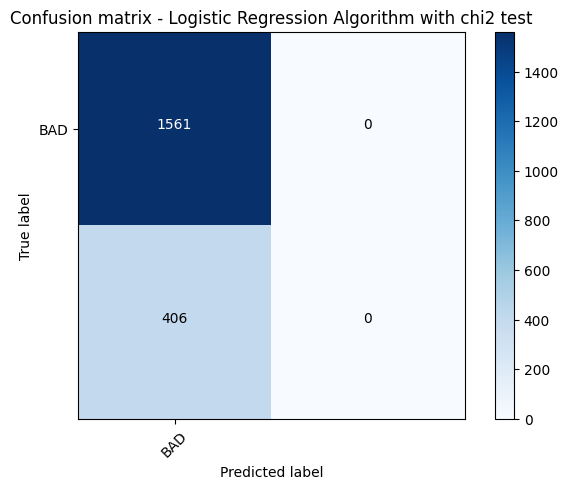

In [43]:
# Running the logistic regression algorithm using the features selected from chi2 test
x = df_new
y = df["BAD"]
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, random_state=1)

logreg = LogisticRegression()
logreg.fit(x_tr, y_tr)
y_pre = logreg.predict(x_te)
y_pre = logreg.predict(x_te)

a5 = accuracy_score(y_te, y_pre)
f5 = f1_score(y_te, y_pre, average="macro")
p5 = precision_score(y_te, y_pre, average="macro")
r5 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a5)
print("f1 score : ", f5)
print("precision score : ", p5)
print("recall score : ", r5)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Logistic Regression Algorithm with chi2 test",
)

plt.show()

accuracy score :  0.8566344687341129
f1 score :  0.76771608040201
precision score :  0.7871279857857255
recall score :  0.7529435154299852
Confusion matrix, without normalization
[[1451  110]
 [ 172  234]]


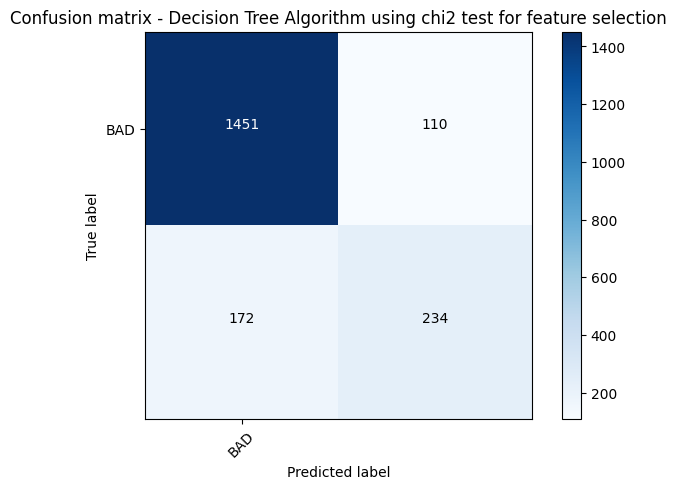

In [44]:
# Decision Tree classifier using features from chi2 test
clf_tree = DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr, y_tr)
y_pre = clf_tree.predict(x_te)

a6 = accuracy_score(y_te, y_pre)
f6 = f1_score(y_te, y_pre, average="macro")
p6 = precision_score(y_te, y_pre, average="macro")
r6 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a6)
print("f1 score : ", f6)
print("precision score : ", p6)
print("recall score : ", r6)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Decision Tree Algorithm using chi2 test for feature selection",
)

plt.show()

In [45]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,...,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,...,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,...,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,...,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,...,0,0,1,0,0,1,0,0,0,0


### Using f_classif for feature selection

In [46]:
from sklearn.feature_selection import f_classif

df_new2 = pd.DataFrame(
    SelectKBest(f_classif, k=10).fit_transform(df.drop(["BAD"], axis=1), df["BAD"])
)
df_new2.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,2.442347,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0,0.0
1,1300.0,2.079442,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0,0.0
2,1500.0,1.609438,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0,0.0
3,1500.0,2.294782,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0,0.0
4,1700.0,1.386294,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0,1.0


accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5
Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


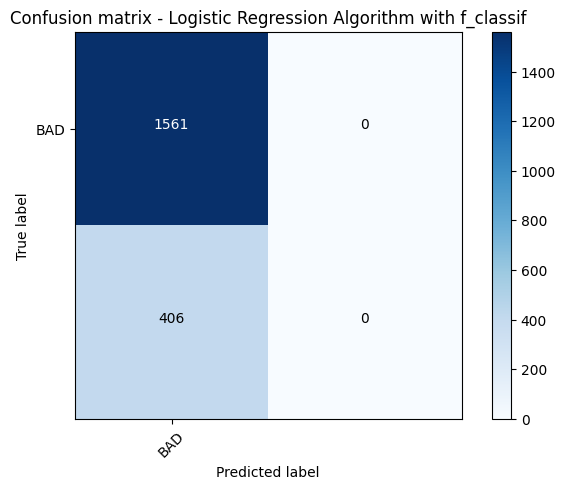

In [47]:
# Running the logistic regression algorithm using the features selected from f_classif test
x = df_new2
y = df["BAD"]

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr, y_tr)
y_pre = logreg.predict(x_te)

a7 = accuracy_score(y_te, y_pre)
f7 = f1_score(y_te, y_pre, average="macro")
p7 = precision_score(y_te, y_pre, average="macro")
r7 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a7)
print("f1 score : ", f7)
print("precision score : ", p7)
print("recall score : ", r7)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Logistic Regression Algorithm with f_classif",
)

plt.show()

accuracy score :  0.8566344687341129
f1 score :  0.7695887028704731
precision score :  0.7860557979172531
recall score :  0.7565883938235878
Confusion matrix, without normalization
[[1447  114]
 [ 168  238]]


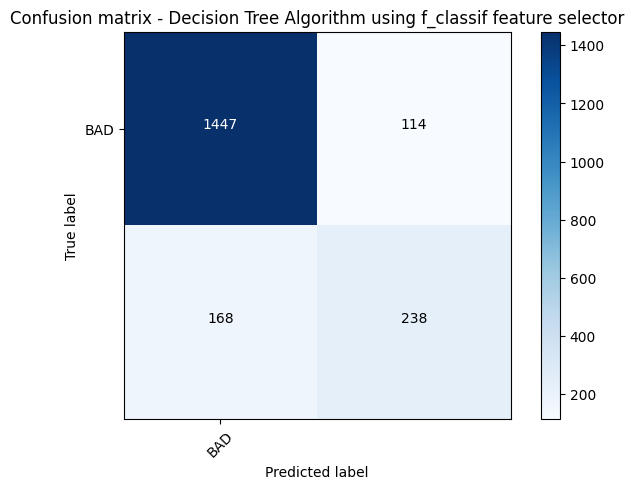

In [48]:
# Decision Tree classifier using features from f_classif test
clf_tree = DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr, y_tr)
y_pre = clf_tree.predict(x_te)

a8 = accuracy_score(y_te, y_pre)
f8 = f1_score(y_te, y_pre, average="macro")
p8 = precision_score(y_te, y_pre, average="macro")
r8 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a8)
print("f1 score : ", f8)
print("precision score : ", p8)
print("recall score : ", r8)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Decision Tree Algorithm using f_classif feature selector",
)

plt.show()

#### To view the decision tree created - 

In [49]:
# import graphviz
# from sklearn import tree

# FIXME dot_dat = tree.export_graphviz(clf_tree, out_file=None)
# FIXME graph = graphviz.Source(dot_dat)
# FIXME graph

### Using f_regression for feature selection

In [50]:
from sklearn.feature_selection import f_regression

df_new3 = pd.DataFrame(
    SelectKBest(f_regression, k=10).fit_transform(df.drop(["BAD"], axis=1), df["BAD"])
)
df_new3.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,2.442347,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0,0.0
1,1300.0,2.079442,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0,0.0
2,1500.0,1.609438,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0,0.0
3,1500.0,2.294782,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0,0.0
4,1700.0,1.386294,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0,1.0


accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5
Confusion matrix, without normalization
[[1447  114]
 [ 168  238]]


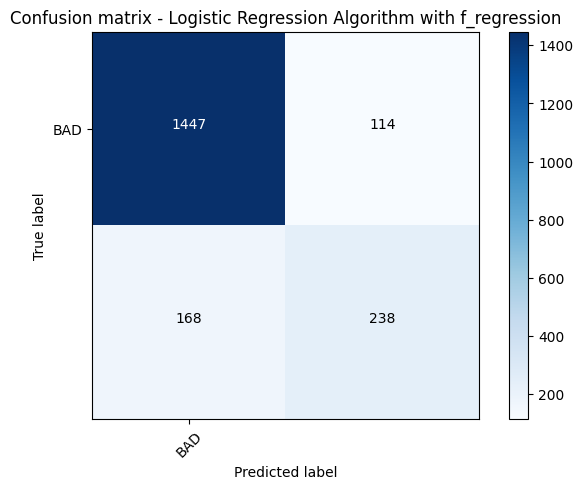

In [51]:
# Running the logistic regression algorithm using the features selected from f_regression test

x = df_new3
y = df["BAD"]
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, random_state=1)

logreg = LogisticRegression()
logreg.fit(x_tr, y_tr)
y_pre2 = logreg.predict(x_te)

a9 = accuracy_score(y_te, y_pre2)
f9 = f1_score(y_te, y_pre2, average="macro")
p9 = precision_score(y_te, y_pre2, average="macro")
r9 = recall_score(y_te, y_pre2, average="macro")

print("accuracy score : ", a9)
print("f1 score : ", f9)
print("precision score : ", p9)
print("recall score : ", r9)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Logistic Regression Algorithm with f_regression",
)

plt.show()

accuracy score :  0.8561260803253686
f1 score :  0.767129637182887
precision score :  0.786109473007023
recall score :  0.7526232079347899
Confusion matrix, without normalization
[[1450  111]
 [ 172  234]]


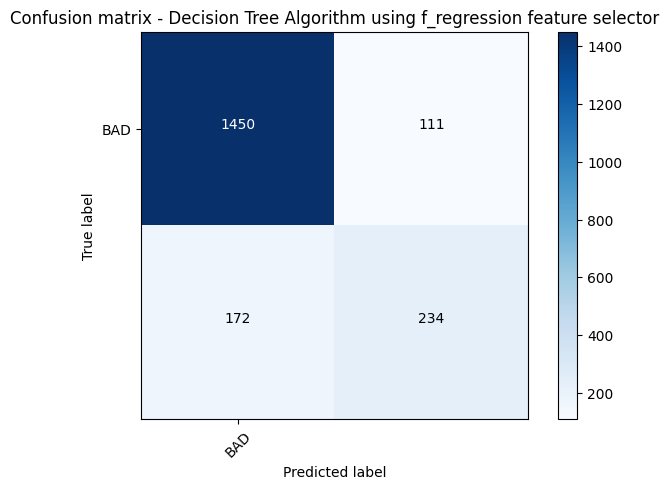

In [52]:
# Decision Tree classifier using features from f_regression test
clf_tree = DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr, y_tr)
y_pre = clf_tree.predict(x_te)

a10 = accuracy_score(y_te, y_pre)
f10 = f1_score(y_te, y_pre, average="macro")
p10 = precision_score(y_te, y_pre, average="macro")
r10 = recall_score(y_te, y_pre, average="macro")

print("accuracy score : ", a10)
print("f1 score : ", f10)
print("precision score : ", p10)
print("recall score : ", r10)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["BAD"],
    title="Confusion matrix - Decision Tree Algorithm using f_regression feature selector",
)

plt.show()

# Comparing all the models
We can now rank our evaluation of all the models to choose the best one for our problem. 

In [53]:
models = pd.DataFrame(
    {
        "Model": [
            "Logistic Regression",
            "Decision Tree",
            "Logistic Regression",
            "Decision Tree",
            "Logistic Regression",
            "Decision Tree",
            "Logistic Regression",
            "Decision Tree",
            "Logistic Regression",
            "Decision Tree",
        ],
        "Feature Selection Method": [
            "None",
            "None",
            "Pearson corr_fact",
            "Pearson corr_fact",
            "chi2 test",
            "chi2 test",
            "f_classif",
            "f_classif",
            "f_regression",
            "f_regression",
        ],
        "Accuracy Score": [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10],
        "Recall Score": [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10],
        "F1 Score": [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10],
        "Precision Score": [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10],
    }
)

In [54]:
models  # pylint: disable=W0104

,Model,Feature Selection Method,Accuracy Score,Recall Score,F1 Score,Precision Score
0,Logistic Regression,None,0.793594,0.500000,0.442460,0.396797
1,Decision Tree,None,0.871378,0.791391,0.798682,0.806843
2,Logistic Regression,Pearson corr_fact,0.793594,0.500000,0.442460,0.396797
3,Decision Tree,Pearson corr_fact,0.849009,0.740849,0.755111,0.774027
4,Logistic Regression,chi2 test,0.793594,0.500000,0.442460,0.396797
5,Decision Tree,chi2 test,0.856634,0.752944,0.767716,0.787128
6,Logistic Regression,f_classif,0.793594,0.500000,0.442460,0.396797
7,Decision Tree,f_classif,0.856634,0.756588,0.769589,0.786056
8,Logistic Regression,f_regression,0.793594,0.500000,0.442460,0.396797
9,Decision Tree,f_regression,0.856126,0.752623,0.767130,0.786109


In [55]:
pd.pivot_table(models, index=["Feature Selection Method", "Model"])

Accuracy Score  F1 Score  \
Feature Selection Method Model                                           
None                     Decision Tree              0.871378  0.798682   
                         Logistic Regression        0.793594  0.442460   
Pearson corr_fact        Decision Tree              0.849009  0.755111   
                         Logistic Regression        0.793594  0.442460   
chi2 test                Decision Tree              0.856634  0.767716   
                         Logistic Regression        0.793594  0.442460   
f_classif                Decision Tree              0.856634  0.769589   
                         Logistic Regression        0.793594  0.442460   
f_regression             Decision Tree              0.856126  0.767130   
                         Logistic Regression        0.793594  0.442460   

                                              Precision Score  Recall Score  
Feature Selection Method Model                                               
None                     Decision Tree               0.806843      0.791391  
                         Logistic Regression         0.396797      0.500000  
Pearson corr_fact        Decision Tree               0.774027      0.740849  
                         Logistic Regression         0.396797      0.500000  
chi2 test                Decision Tree               0.787128      0.752944  
                         Logistic Regression         0.396797      0.500000  
f_classif                Decision Tree               0.786056      0.756588  
                         Logistic Regression         0.396797      0.500000  
f_regression             Decision Tree               0.786109      0.752623  
                         Logistic Regression         0.396797      0.500000

# Discussion and Insights :
- Logistic Regression produced results with a good accuracy but overall performance is not that good. 
<br>
- Decision Tree dominated over Logistic Regression in all cases.
<br>
- As mentioned earlier, the performance of Decision tree remained almost the same from the start since it does feature selection inheritly. Also performance of Logistic Regression got better after feature selection process.
<br>
- Finally Decision Tree model with feature selector f_classf would be the best method to use because it has the Highest RECALL value
<br>
- The maximum depth of the decision tree is set to 100 in all cases hence number of levels is 101 in all cases. And since we did not set the minimum number of observations in the leaf will be 1 since it is classification problem.
<br>
- The threshold is defaultly set to .5 in Logistic Regression!
<br>
- Obviously,changing the threshold affects the performance of the model and this can be observed in the next section.
<br>
- This can be further extended by Resampling of the data to increase the RECALL score

#### Using decision tree with f_classif feature selector would give the best results!!

# Changing the threshold and observing the performance :

Recall metric in the testing dataset:  0.6330049261083743
Accuracy score for the testing dataset:  0.5663446873411286
Confusion matrix, without normalization
[[857 704]
 [149 257]]

Recall metric in the testing dataset:  0.6330049261083743
Accuracy score for the testing dataset:  0.5663446873411286
Confusion matrix, without normalization
[[857 704]
 [149 257]]

Recall metric in the testing dataset:  0.6330049261083743
Accuracy score for the testing dataset:  0.5663446873411286
Confusion matrix, without normalization
[[857 704]
 [149 257]]

Recall metric in the testing dataset:  0.6330049261083743
Accuracy score for the testing dataset:  0.5663446873411286
Confusion matrix, without normalization
[[857 704]
 [149 257]]

Recall metric in the testing dataset:  0.6330049261083743
Accuracy score for the testing dataset:  0.5663446873411286
Confusion matrix, without normalization
[[857 704]
 [149 257]]

Recall metric in the testing dataset:  0.0
Accuracy score for the testing dataset:  0.7935

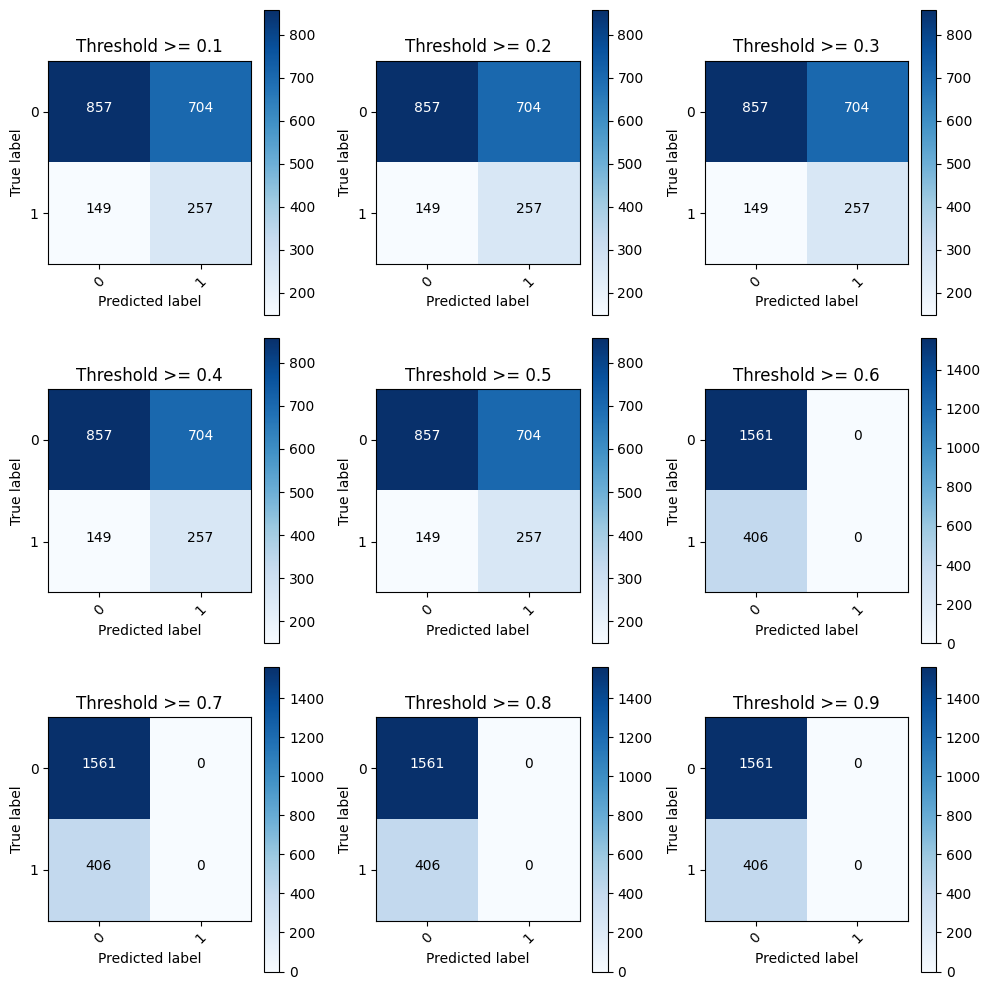

In [56]:
lr = LogisticRegression()
lr.fit(x_tr, y_tr)
y_pred_proba = lr.predict_proba(x_te)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(10, 10))

j = 1

for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:, 1] >= i

    plt.subplot(3, 3, j)
    j += 1

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_te, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    rec1 = recall_score(y_te, y_test_predictions_high_recall)
    numerator = 1.0 * (cnf_matrix[0, 0] + cnf_matrix[1, 1])
    divisor = cnf_matrix[0, 0] + cnf_matrix[1, 0] + cnf_matrix[1, 1] + cnf_matrix[0, 1]
    acc = numerator / divisor
    print("Recall metric in the testing dataset: ", rec1)
    print("Accuracy score for the testing dataset: ", acc)
    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title=f"Threshold >= {i}")
    print("")

#### Conclusion :
- The values of recall and accuracy vary with the threshold selected.
- Based on the required accuracy and recall values , one has to decide and select a threshold.
- It is suggested to move on with the default threshold that is 0.5 in general cases.
<br>
------------------------------------------------------------------------------------------------------------------------------

# More on this : Using RESAMPLING to increase the recall value

- As mentioned earlier, we can use Resampling to improve the performance of the learning algorithms.
- In this method we are going to divide the data to have the target class ratio 1:1.
- Essentially this is a method that will process the data to have an approximate 50-50 ratio.
- There are 2 processesto do this, Under-Sampling and Over-Sampling. Here we are going to use UNDER-SAMPLING.

In [57]:
# Getting length and indices of minority class.
default_len = len(df[df["BAD"] == 1])
default_indices = np.array(df[df["BAD"] == 1].index)

# Selecting the same number of elements from majority class randomly.
good_indices = np.array(df[df["BAD"] == 0].index)
rand_good_indices = np.random.choice(good_indices, default_len, replace=False)
rand_good_indices = np.array(rand_good_indices)

# Combining the indices
combined_indices = np.concatenate([rand_good_indices, default_indices])

# Getting the corresponding dataset with above indices.
comb_df = df.iloc[combined_indices, :]
comb_y = comb_df["BAD"]

In [58]:
# Using the f_classif feature selection method which produced good results in above cases

comb_x = pd.DataFrame(
    SelectKBest(f_classif, k=10).fit_transform(comb_df.drop(["BAD"], axis=1), comb_df["BAD"])
)
comb_x.head()

,0,1,2,3,4,5,6,7,8,9
0,17900.0,37265.0,0.0,0.0,259.963831,0.0,39.831501,0.0,0.0,1.0
1,10000.0,63218.0,2.0,3.0,183.666667,3.0,33.779915,1.0,1.0,0.0
2,6600.0,68733.0,0.0,0.0,96.977667,0.0,42.211047,0.0,0.0,0.0
3,43200.0,15635.0,0.0,0.0,212.115280,0.0,40.460676,0.0,0.0,0.0
4,34100.0,241931.0,0.0,2.0,196.008832,3.0,42.458582,0.0,1.0,0.0


In [59]:
# Spliting the data into train and test datasets

x_trc, x_tec, y_trc, y_tec = train_test_split(comb_x, comb_y, test_size=0.33, random_state=1000)

In [60]:
# Using Kfold scores to train the data since very less data is available
# FIXME: help here, or delete

# from sklearn.model_selection import KFold, cross_val_score

# lr = LogisticRegression()

# def printing_Kfold_scores(x_trc,y_trc):

#     fold = KFold(len(y_trc),4,shuffle=False)

#     for train,test in fold.split() :
#         x1 = x_trc.iloc[train,:]
#         y1 = y_trc.iloc[train]
#         x2 = x_trc.iloc[test,:]
#         y2 = y_trc.iloc[test]
#         lr.fit(x1,y1)
#         y_pred_undersample = lr.predict(x2)
#         recall_acc = recall_score(y2,y_pred_undersample)
#         print(recall_acc)

# printing_Kfold_scores(x_trc,y_trc)

# y_predr = lr.predict(x_tec)

# print("")
# print('Accuracy Score = ',accuracy_score(y_tec,y_predr))
# print('F1 Score = ',f1_score(y_tec, y_predr, average="macro"))
# print('Precision Score = ',precision_score(y_tec, y_predr, average="macro"))
# print('Recall Score = ',recall_score(y_tec, y_predr, average="macro"))
# print("")

# cnf_matrix = confusion_matrix(y_tec, y_predr)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=["BAD"],
#      title='Confusion matrix - Logistic Regression Algorithm after Resampling the data')

# plt.show()

In [61]:
# FIXME: same

# lr = DecisionTreeClassifier()

# def printing_Kfold_scores(x_trc,y_trc):

#     print("Decision Tree Algorithm")
#     fold = KFold(len(y_trc),4,shuffle=False)
#     for train,test in fold :
#         x1 = x_trc.iloc[train,:]
#         y1 = y_trc.iloc[train]
#         x2 = x_trc.iloc[test,:]
#         y2 = y_trc.iloc[test]
#         lr.fit(x1,y1)
#         y_pred_undersample = lr.predict(x2)
#         recall_acc = recall_score(y2,y_pred_undersample)
#         print(recall_acc)

# printing_Kfold_scores(x_trc,y_trc)

# y_predr = lr.predict(x_tec)
# print("")
# print('Accuracy Score = ',accuracy_score(y_tec,y_predr))
# print('F1 Score = ',f1_score(y_tec, y_predr, average="macro"))
# print('Precision Score = ',precision_score(y_tec, y_predr, average="macro"))
# print('Recall Score = ',recall_score(y_tec, y_predr, average="macro"))
# print("")

# cnf_matrix = confusion_matrix(y_tec, y_predr)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=["BAD"],
#    title='Confusion matrix - Decision Tree Algorithm after Resampling the data')

# plt.show()

#### Conclusion :
- As you can see that, Recall has INCREASED by about 5-7% in case of Logistic Regression by Resampling the data.This is a huge achievement !!
<br>
- In case of Decision Tree Algorithm, recall is more or less the same.

## Overall conclusion

Remark how simply we were able to replace scikit-learn models by their Concrete-ML counterpart, and that the accuracy was directly equivalent to the original accuracy.